# Import libraries

In [1]:
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras import layers
from keras import backend as K
from keras.layers import SeparableConv2D
from keras.regularizers import l2

import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.
/home/sven/anaconda3/envs/keras2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sven/anaconda3/envs/keras2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sven/anaconda3/envs/keras2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sven/anaconda3/envs/

In [2]:
trainingset = np.loadtxt('fer2013_training_onehot.csv', delimiter=',')
testingset = np.loadtxt('fer2013_publictest_onehot.csv', delimiter=',')
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

In [3]:
n_inputs = 2304
n_classes = 7
img_dim = 48

x_training = trainingset[:, 0:n_inputs]
y_training = trainingset[:, n_inputs:n_inputs + n_classes]

x_testing = testingset[:, 0:n_inputs]
y_testing = testingset[:, n_inputs:n_inputs + n_classes]

x_training = x_training.reshape(x_training.shape[0], 48, 48)
x_training = np.expand_dims(x_training, axis=4)

x_testing = x_testing.reshape(x_testing.shape[0], 48, 48)
x_testing = np.expand_dims(x_testing, axis=4)


/home/sven/anaconda3/envs/keras2/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  if sys.path[0] == '':
/home/sven/anaconda3/envs/keras2/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  from ipykernel import kernelapp as app


In [5]:
input_image = Input(shape=(48, 48, 1), name='Input')

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv1')(input_image)
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv2')(x)
x = BatchNormalization(name='batchnormal1')(x)
x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv3')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool1')(x)
x = Dropout(rate=0.4, name='dropout1')(x)

residual = Conv2D(128, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=l2(0.01),use_bias=False,name='se_conv1')(x)
x = BatchNormalization(name='batchnormal2')(x)
x = Activation('relu')(x)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=l2(0.01),use_bias=False, name='se_conv2')(x)
x = BatchNormalization(name='batchnormal3')(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='pool2')(x)
x = layers.add([x, residual])

x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv4')(x)
x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv5')(x)
x = BatchNormalization(name='batchnormal4')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool3')(x)

x = Dropout(rate=0.4, name='dropout2')(x)
x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', name='conv6')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool4')(x)
x = Dropout(rate=0.4, name='dropout3')(x)
x = Flatten(name='flatten')(x)

x = Dense(units=1024, activation='relu', name='fc1')(x)
x = Dropout(rate=0.5, name='dropout4')(x)
x = Dense(units=128, activation='relu', name='fc4')(x)
x = Dropout(rate=0.5, name='dropout5')(x)

output_label = Dense(units=n_classes, activation='softmax', name='softmax')(x)

model = Model(inputs=input_image, outputs=output_label, name='ez')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   640         Input[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 48, 48, 64)   36928       conv1[0][0]                      
__________________________________________________________________________________________________
batchnormal1 (BatchNormalizatio (None, 48, 48, 64)   256         conv2[0][0]                      
__________________________________________________________________________________________________
conv3 (Con

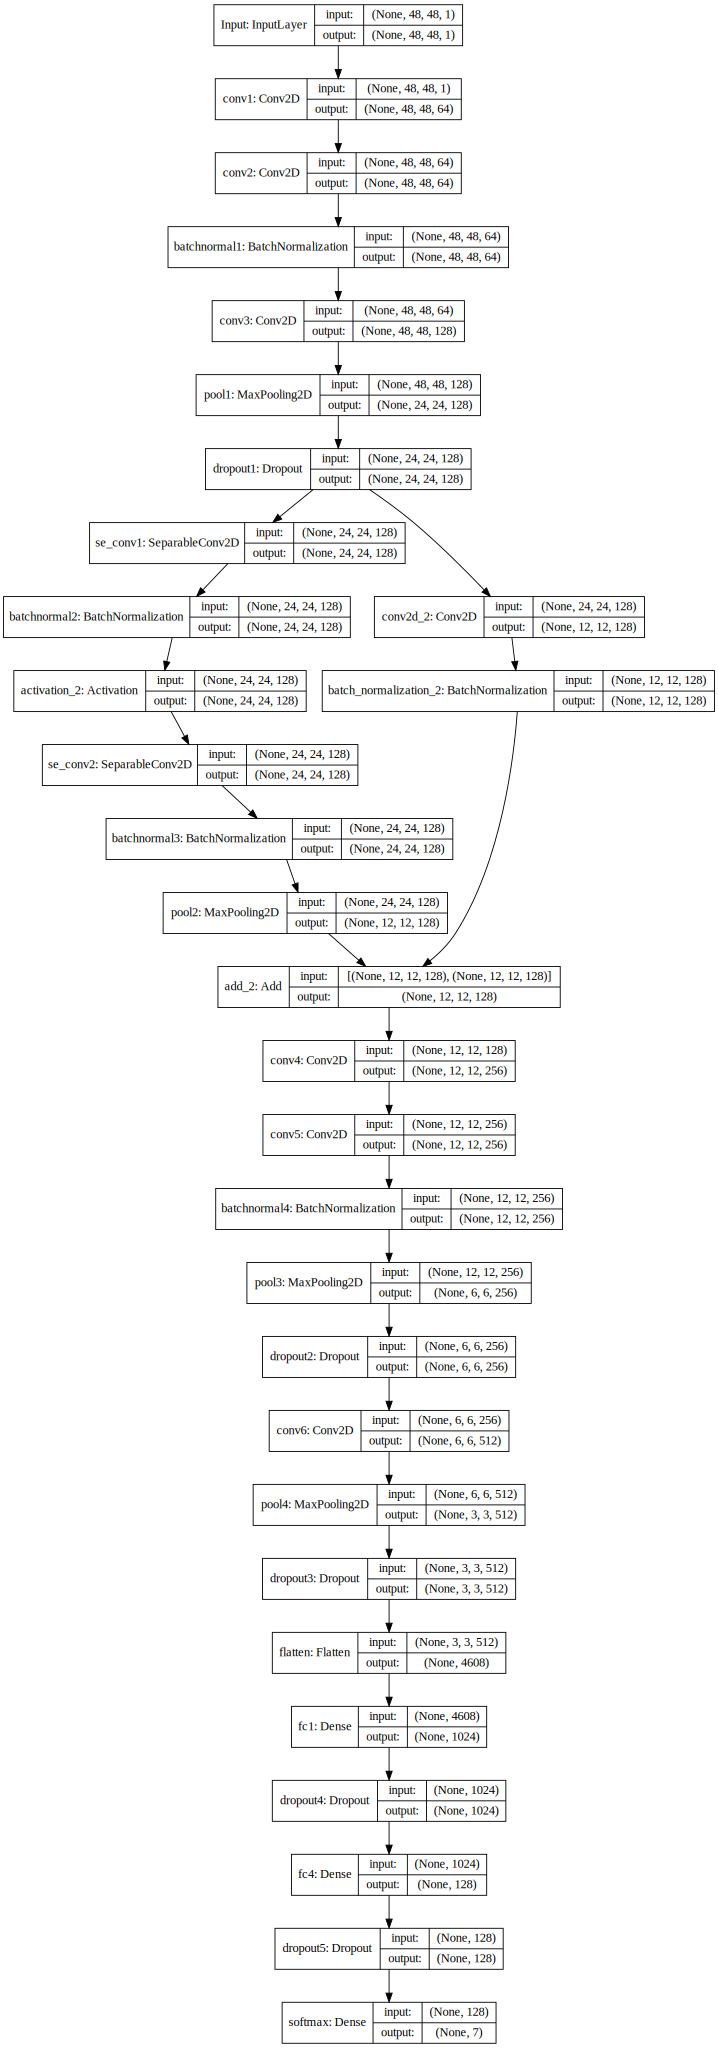

In [6]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [10]:
MODELPATH = './models'
loss = 'categorical_crossentropy'
model.load_weights("models")
model.compile(loss=loss, optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), metrics=['accuracy'])
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=1)
tensorboard = TensorBoard(log_dir='./logs')
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(MODELPATH, monitor='val_loss', verbose=1, save_best_only=True)
batch_size = 256
epochs = 100
starting_time = time.time()
history = model.fit_generator(data_generator.flow(x_training, y_training,batch_size),
                    validation_data=(x_testing, y_testing),
                    steps_per_epoch=len(x_training) / batch_size,
                    epochs=epochs,
                    shuffle=True,
                    callbacks=[lr_reducer, tensorboard, early_stopper, checkpointer])

print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

Epoch 1/100
113/112 [==============================] - 20s 175ms/step - loss: 0.8738 - acc: 0.6833 - val_loss: 1.0136 - val_acc: 0.6250

Epoch 00001: val_loss improved from inf to 1.01358, saving model to ./models
Epoch 2/100
113/112 [==============================] - 19s 167ms/step - loss: 0.8610 - acc: 0.6869 - val_loss: 0.9376 - val_acc: 0.6604

Epoch 00002: val_loss improved from 1.01358 to 0.93765, saving model to ./models
Epoch 3/100
113/112 [==============================] - 19s 168ms/step - loss: 0.8413 - acc: 0.6920 - val_loss: 0.9528 - val_acc: 0.6525

Epoch 00003: val_loss did not improve from 0.93765
Epoch 4/100
113/112 [==============================] - 19s 168ms/step - loss: 0.8265 - acc: 0.6963 - val_loss: 0.9658 - val_acc: 0.6551

Epoch 00004: val_loss did not improve from 0.93765
Epoch 5/100
113/112 [==============================] - 20s 175ms/step - loss: 0.8310 - acc: 0.6983 - val_loss: 0.9613 - val_acc: 0.6595

Epoch 00005: val_loss did not improve from 0.93765
Epoc

In [11]:
score = model.evaluate(x_testing, y_testing)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3589/3589 [==============================] - 1s 351us/step
Test loss: 0.9460930789569919
Test accuracy: 0.6642518807799412


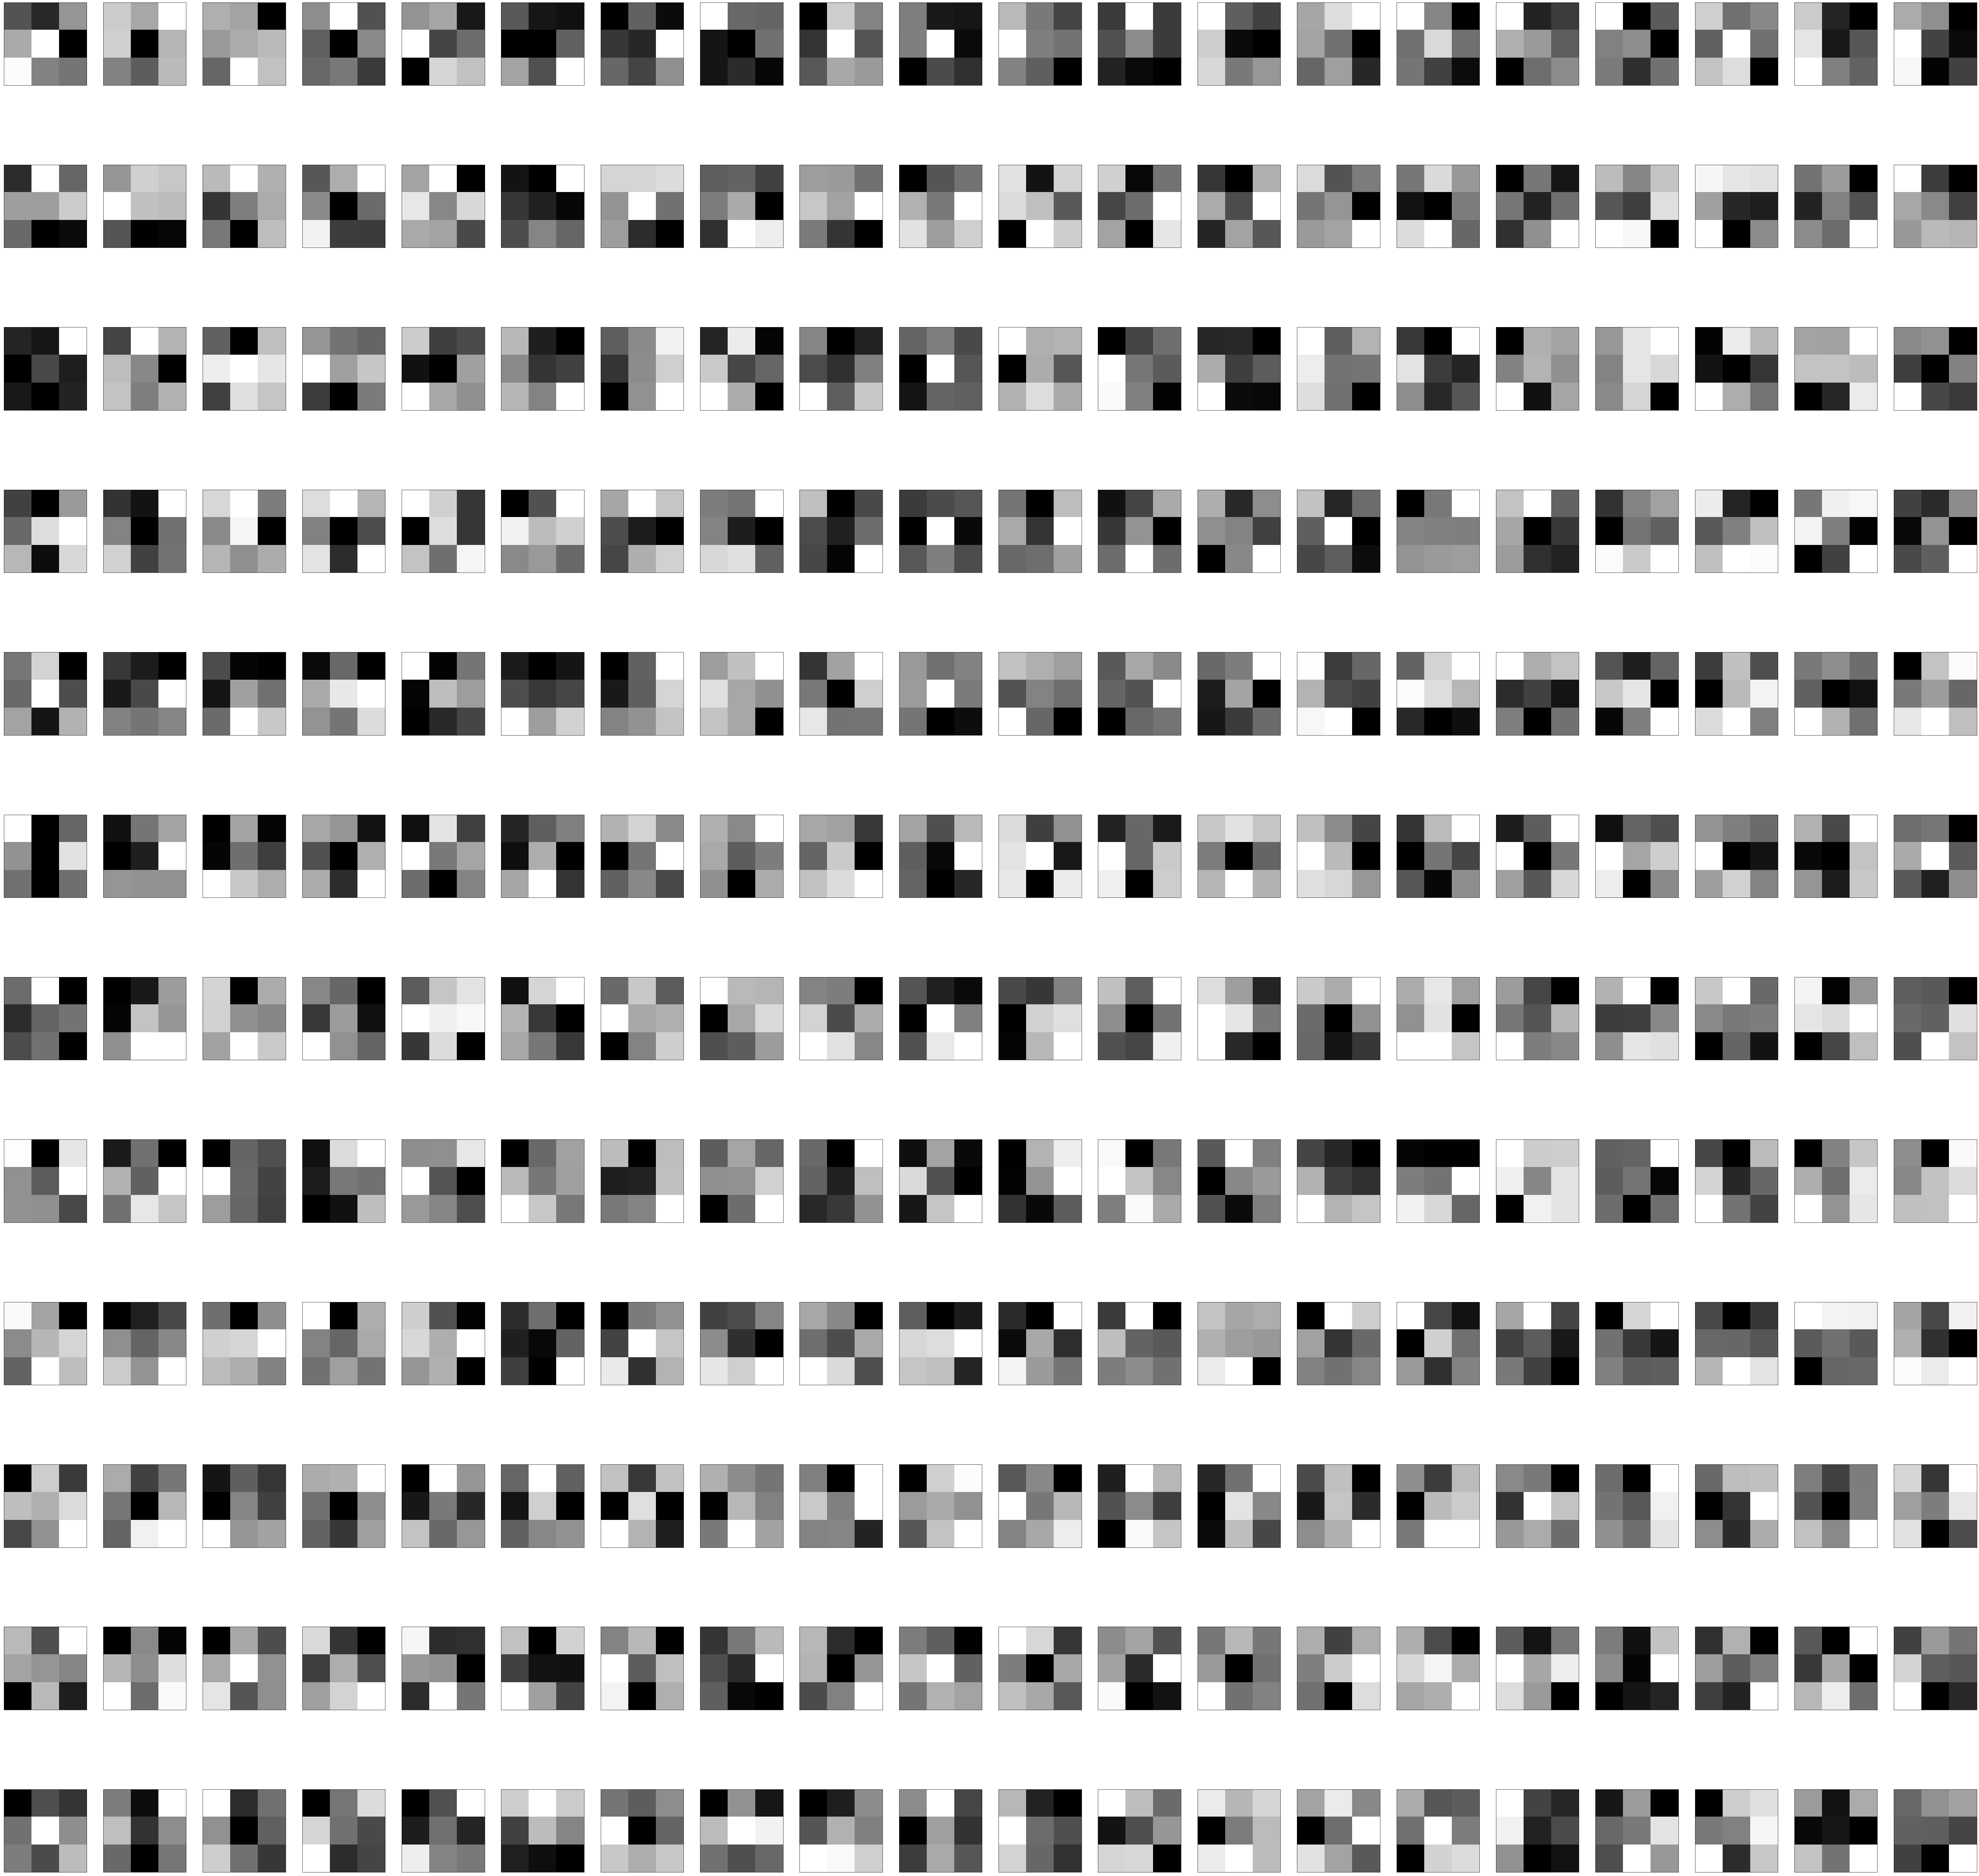

In [12]:
# retrieve weights from the last convolutional layer 
filters, biases = model.get_layer('conv6').get_weights()
# normalize filter values to 0-1 
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
plt.figure(figsize=(100,100))
# plotting the firstly 12 filters in 20 of 256 channels from the last convolutional layer 
n_filters, ix = 12, 1 
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(20):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 20, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
plt.show()